In [11]:
import pandas as pd
import numpy as np

df = pd.read_csv("../data/raw/Raw_dataset.csv", comment='#')
print("Initial shape:", df.shape)
df.head()


C:\Users\sruja\AppData\Local\Temp\ipykernel_24408\1751086467.py:4: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/raw/Raw_dataset.csv", comment='#')


Initial shape: (38825, 289)


,rowid,pl_name,hostname,pl_letter,hd_name,hip_name,tic_id,gaia_dr2_id,gaia_dr3_id,default_flag,...,rowupdate,pl_pubdate,releasedate,pl_nnotes,st_nphot,st_nrvc,st_nspec,pl_nespec,pl_ntranspec,pl_ndispec
0,1,11 Com b,11 Com,b,HD 107383,HIP 60202,TIC 72437047,Gaia DR2 3946945413106333696,Gaia DR3 3946945413106333696,1,...,19-09-2023,2023-08,19-09-2023,2.0,1.0,2.0,0.0,0.0,0.0,0.0
1,2,11 Com b,11 Com,b,HD 107383,HIP 60202,TIC 72437047,Gaia DR2 3946945413106333696,Gaia DR3 3946945413106333696,0,...,14-05-2014,2008-01,14-05-2014,2.0,1.0,2.0,0.0,0.0,0.0,0.0
2,3,11 Com b,11 Com,b,HD 107383,HIP 60202,TIC 72437047,Gaia DR2 3946945413106333696,Gaia DR3 3946945413106333696,0,...,23-07-2014,2011-08,23-07-2014,2.0,1.0,2.0,0.0,0.0,0.0,0.0
3,4,11 UMi b,11 UMi,b,HD 136726,HIP 74793,TIC 230061010,Gaia DR2 1696798367260229376,Gaia DR3 1696798367260229376,0,...,25-04-2018,2009-10,14-05-2014,0.0,1.0,1.0,0.0,0.0,0.0,0.0
4,5,11 UMi b,11 UMi,b,HD 136726,HIP 74793,TIC 230061010,Gaia DR2 1696798367260229376,Gaia DR3 1696798367260229376,1,...,04-09-2018,2017-03,06-09-2018,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [12]:
keep_cols = [
    "pl_rade", "pl_masse", "pl_dens", "pl_eqt","pl_orbsmax","pl_orbeccen","pl_insol",
    "pl_orbper", "st_teff", "st_lum", "st_met", "st_spectype","st_rad","st_mass","sy_dist"
]
df = df[keep_cols]
print("After selecting columns:", df.shape)


After selecting columns: (38825, 15)


In [13]:
# Numerical → median
num_cols = df.select_dtypes(include=[np.number]).columns
for col in num_cols:
    df[col] = df[col].fillna(df[col].median())

# Categorical → mode
cat_cols = df.select_dtypes(include=['object', 'category']).columns
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0] if not df[col].mode().empty else "Unknown")

print("Remaining missing values:", df.isna().sum().sum())


Remaining missing values: 0


In [14]:
#clipping outliers
#Quantile based clipping(winsorzation)
num_cols = df.select_dtypes(include=[np.number]).columns

for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f"{col}: {outliers.shape[0]} outliers detected")

for col in num_cols:
    lower = df[col].quantile(0.05)
    upper = df[col].quantile(0.95)
    df[col] = df[col].clip(lower, upper)


pl_rade: 5355 outliers detected
pl_masse: 4606 outliers detected
pl_dens: 2636 outliers detected
pl_eqt: 17060 outliers detected
pl_orbsmax: 11911 outliers detected
pl_orbeccen: 4206 outliers detected
pl_insol: 17070 outliers detected
pl_orbper: 5146 outliers detected
st_teff: 2882 outliers detected
st_lum: 9560 outliers detected
st_met: 7795 outliers detected
st_rad: 2600 outliers detected
st_mass: 3303 outliers detected
sy_dist: 1336 outliers detected


In [15]:
# exponential scoring
def habitability_score(row):
    return (np.exp(-abs(row['pl_rade'] - 1.0)/1.0) *
            np.exp(-abs(row['pl_dens'] - 5.51)/5.0) *
            np.exp(-abs(row['pl_eqt'] - 255)/50.0) *
            np.exp(-abs(row['pl_insol'] - 1)/1.0)) ** 0.25

def stellar_index(row):
    return (np.exp(-abs(row['st_teff'] - 5778)/1000.0) *
            np.exp(-abs(row['st_lum'] - 1)/1.0) *
            np.exp(-abs(row['st_met'] - 0)/0.5)) ** (1/3)

df['habitability_score'] = df.apply(habitability_score, axis=1)
df['stellar_compatibility'] = df.apply(stellar_index, axis=1)

df[['habitability_score','stellar_compatibility']].describe()


,habitability_score,stellar_compatibility
count,3.882500e+04,38825.000000
mean,2.611861e-03,0.562247
std,1.093214e-02,0.106205
min,0.000000e+00,0.250785
25%,1.840558e-12,0.507968
50%,2.202154e-11,0.580271
75%,3.713356e-11,0.649907
max,7.558481e-02,0.805811


In [16]:
df = pd.get_dummies(df, columns=['st_spectype'], prefix='star_type')


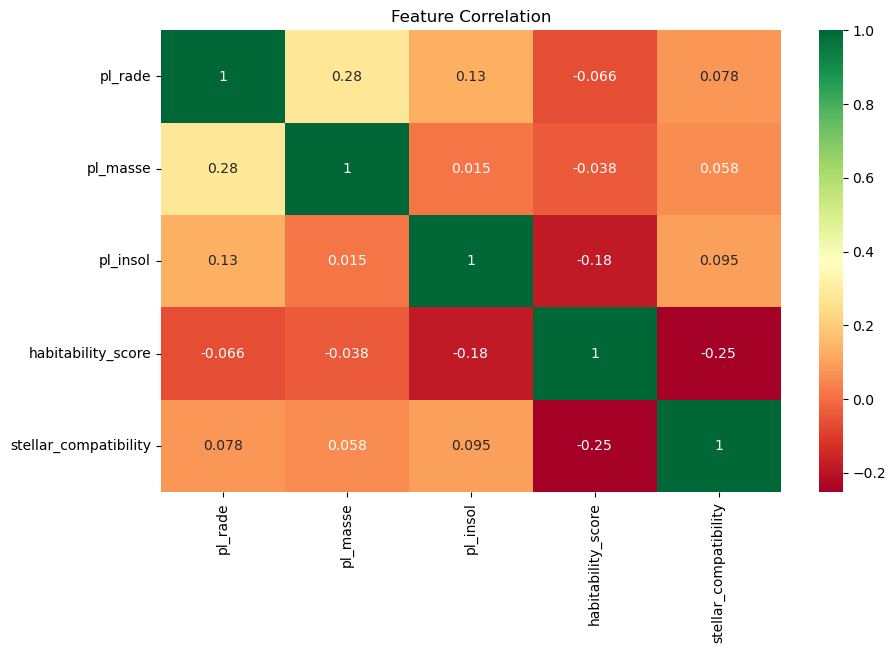

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.heatmap(
    df[['pl_rade','pl_masse','pl_insol','habitability_score','stellar_compatibility']].corr(),
    annot=True,
    cmap='RdYlGn'
)
plt.title("Feature Correlation")
plt.show()


In [18]:
from sklearn.preprocessing import StandardScaler

numerical_features = df.select_dtypes(include=[np.number]).columns
scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

df.head()

,pl_rade,pl_masse,pl_dens,pl_eqt,pl_orbsmax,pl_orbeccen,pl_insol,pl_orbper,st_teff,st_lum,...,star_type_M7.0 V,star_type_M7.25,star_type_M7.5,star_type_M8,star_type_M8.0 V,star_type_M8.5,star_type_M9,star_type_M9-L1,star_type_WD,star_type_m3 V
0,-0.294293,0.015077,4.440892e-16,-0.110152,3.817474,3.786449,-0.301266,3.607284,-0.909888,2.557715,...,False,False,False,False,False,False,False,False,False,False
1,-0.294293,0.015077,4.440892e-16,-0.110152,3.817474,3.786449,-0.301266,3.607284,-1.113465,2.557715,...,False,False,False,False,False,False,False,False,False,False
2,-0.294293,0.015077,4.440892e-16,-0.110152,3.817474,-0.308271,-0.301266,-0.373251,0.229833,0.002033,...,False,False,False,False,False,False,False,False,False,False
3,-0.294293,0.015077,4.440892e-16,-0.110152,3.817474,1.875580,-0.301266,3.607284,-1.733449,0.002033,...,False,False,False,False,False,False,False,False,False,False
4,-0.294293,0.015077,4.440892e-16,-0.110152,3.817474,1.875580,-0.301266,3.607284,-1.929315,0.002033,...,False,False,False,False,False,False,False,False,False,False


In [21]:
df.to_csv('../data/processed/cleaned_exoplanet_final.csv', index=False)
print("Final CSV saved. Ready for submission.")


Final CSV saved. Ready for submission.
